In [3]:
import numpy as np
import cv2 as cv

def remove_hair(images, cfg=None):
    """
    Removes hair artifacts from a list of RGB images.
    Returns a list of cleaned (filtered) images with hairs removed.
    """

    if cfg is None:
        class CFG():
            def __init__(self):
                self.edge_low_threshold = 100
                self.edge_high_threshold = 220
                self.dark_spot_threshold = 150
                self.linelength_threshold = 10
                self.divergence_threshold = 0.25
                self.patchiness_threshold = 0.15
                self.interp_win = 20
        cfg = CFG()

    img_filtered_all = []

    for img_orig in images:
        image_size = img_orig.shape[:2]

        # Convert to grayscale if RGB
        if img_orig.ndim == 3:
            RGB_input = True
            img = img_orig.mean(-1)
        else:
            RGB_input = False
            img = img_orig.copy()

        skip_flag = False

        # --- Hair detection pipeline ---
        kernel = np.ones((3,3), np.uint8)
        img_filt = cv.morphologyEx(np.uint8(img), cv.MORPH_BLACKHAT, kernel)
        img_filt = np.where(img_filt > 15, img_filt, 0)

        kernel = np.ones((4,4), np.uint8)
        img_filt = cv.morphologyEx(img_filt, cv.MORPH_DILATE, kernel)

        dark_spots = (img < cfg.dark_spot_threshold).astype(np.uint8)
        kernel = np.ones((4,4), np.uint8)
        dark_spots = cv.morphologyEx(dark_spots, cv.MORPH_DILATE, kernel)

        img_filt = img_filt * dark_spots

        lines = cv.HoughLinesP(img_filt, cv.HOUGH_PROBABILISTIC, np.pi / 90, 20, None, 1, 20)
        if lines is not None:
            lines = lines.reshape(-1, 4)
            lines_to_interp = []
            for line in lines:
                x, y = fill_line(line[0::2], line[1::2], 1)
                line_length = np.sqrt((line[0] - line[2])**2 + (line[1] - line[3])**2)
                if line_length >= cfg.linelength_threshold:
                    lines_to_interp.append((x, y))
        else:
            skip_flag = True

        # --- Build hair mask ---
        if skip_flag or len(lines_to_interp) == 0:
            Mask = np.zeros(image_size)
        else:
            Mask = np.zeros_like(img_filt)
            for (x, y) in lines_to_interp:
                Mask[y, x] = 1
            kernel = np.ones((3,3), np.uint8)
            Mask = cv.morphologyEx(Mask, cv.MORPH_DILATE, kernel).astype(float)

            # Filter false positives
            i, j = np.where(Mask != 0)
            if i.size == 0:
                Mask = np.zeros(image_size)
            else:
                x_patch = np.std(j) / Mask.shape[1]
                y_patch = np.std(i) / Mask.shape[0]
                x_div = np.abs(0.5 - np.mean(i) / Mask.shape[0])
                y_div = np.abs(0.5 - np.mean(j) / Mask.shape[1])
                patchiness = np.sqrt(x_patch * y_patch)
                divergence = np.max([x_div, y_div])
                if (divergence < cfg.divergence_threshold) and (patchiness < cfg.patchiness_threshold):
                    Mask = np.zeros(image_size)

        # --- Apply inpainting to remove hair ---
        mask_uint8 = (Mask * 255).astype(np.uint8)
        img_filtered = cv.inpaint(img_orig.astype(np.uint8), mask_uint8, inpaintRadius=3, flags=cv.INPAINT_TELEA)

        img_filtered_all.append(img_filtered)

    return img_filtered_all


def fill_line(x, y, step=1):
    """Generates pixel coordinates along a line between two points."""
    if x[0] == x[1]:
        ys = np.arange(min(y), max(y), step)
        xs = np.repeat(x[0], ys.size)
    else:
        m = (y[1] - y[0]) / (x[1] - x[0])
        xs = np.arange(x[0], x[1], step * np.sign(x[1]-x[0]))
        ys = y[0] + m * (xs - x[0])
    return xs.astype(int), ys.astype(int)

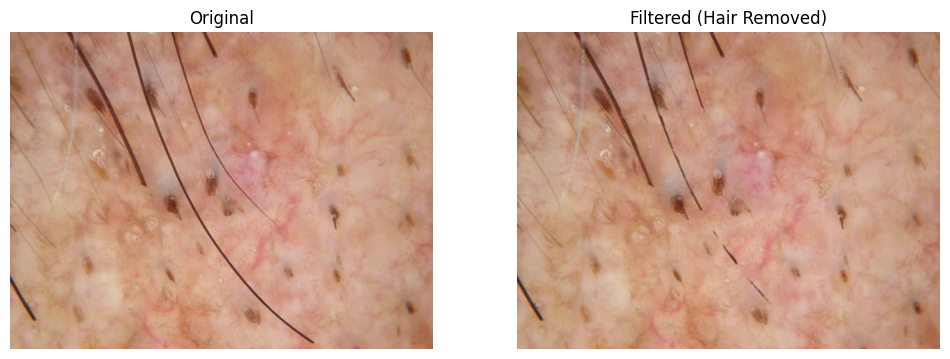

In [5]:
import cv2
import matplotlib.pyplot as plt

img_path = "/Users/ammaster10/Documents/SIIT/QMUL/SkinLesionDataset/Test/Combined/Nevus_0010560.jpg"
# Load image
img = cv.imread(img_path)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

# Apply hair removal
filtered = remove_hair([img])[0]

# Display comparison
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(filtered)
plt.title("Filtered (Hair Removed)")
plt.axis('off')
plt.show()

In [ ]:
# 1. Import the library
from inference_sdk import InferenceHTTPClient
from dotenv import load_dotenv
import os
load_dotenv()

# 2. Connect to your workflow
client = InferenceHTTPClient(
    api_url="https://serverless.roboflow.com",
    api_key= os.getenv("RoboflowAPI")
)

# 3. Run your workflow on an image
result = client.run_workflow(
    workspace_name="qmul-lfuwr",
    workflow_id="custom-workflow-2",
    images={
        "image": "YOUR_IMAGE.jpg" # Path to your image file
    },
    use_cache=True # Speeds up repeated requests
)

# 4. Get your results
print(result)
